In [21]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping

In [22]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [23]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [24]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

      unrate  psr       m2    dspic      pce    reer       

In [25]:
ticker='TSLA'

In [26]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [27]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [28]:
dates = pd.to_datetime(df['Date'])

In [29]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [30]:
df_for_training = df[cols].astype(float)

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [32]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [33]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [34]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [35]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [36]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 16)
(1251, 1)


In [37]:
size=1125
X_train=X[0:size,:]
X_test=X[size:,:]
y_train=y[0:size,:]
y_test=y[size:,:]


#early stopping


Epoch 1/100


6/6 [==============================] - 2s 61ms/step - loss: 0.0189 - val_loss: 0.0047
Epoch 2/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 3/100
6/6 [==============================] - 0s 36ms/step - loss: 0.0100 - val_loss: 0.0067
Epoch 4/100
6/6 [==============================] - 0s 36ms/step - loss: 0.0044 - val_loss: 0.0065


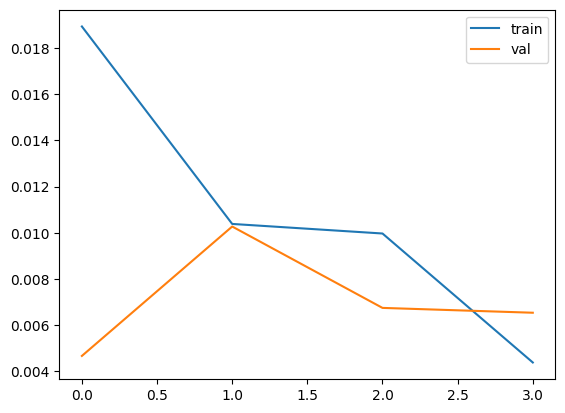

4/4 [==============================] - 0s 4ms/step
mae: 2.2207938308153907


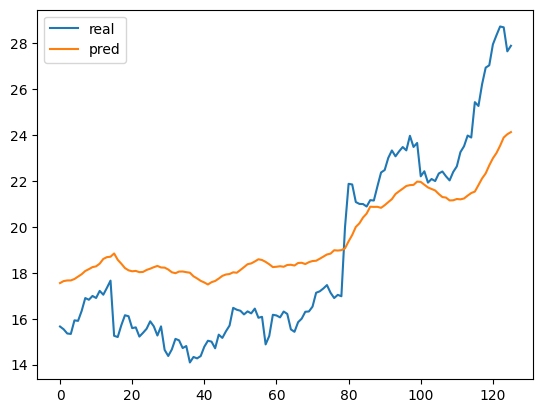

Epoch 1/100
12/12 [==============================] - 2s 41ms/step - loss: 0.0244 - val_loss: 0.0077
Epoch 2/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0164 - val_loss: 0.0171
Epoch 3/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 4/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 5/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 6/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 7/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/100
12/12 [==============================] - 0s 30ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0012 - val_loss: 9.9827

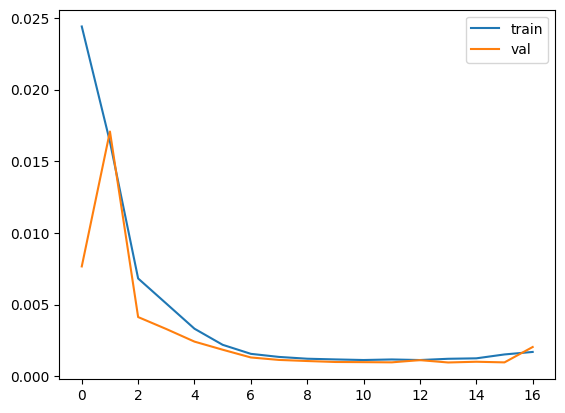

4/4 [==============================] - 0s 4ms/step
mae: 1.8060729170633953


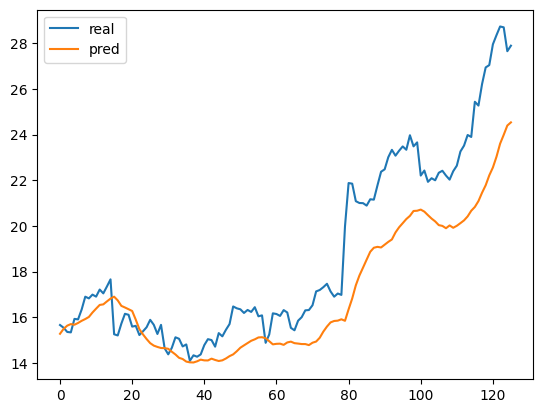

Epoch 1/100
18/18 [==============================] - 2s 38ms/step - loss: 0.0303 - val_loss: 0.0874
Epoch 2/100
18/18 [==============================] - 1s 29ms/step - loss: 0.0073 - val_loss: 0.0544
Epoch 3/100
18/18 [==============================] - 1s 29ms/step - loss: 0.0057 - val_loss: 0.0424
Epoch 4/100
18/18 [==============================] - 1s 29ms/step - loss: 0.0038 - val_loss: 0.0146
Epoch 5/100
18/18 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 0.0065
Epoch 6/100
18/18 [==============================] - 0s 27ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 7/100
18/18 [==============================] - 1s 29ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 8/100
18/18 [==============================] - 1s 28ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 9/100
18/18 [==============================] - 1s 28ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 10/100
18/18 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 0.0028

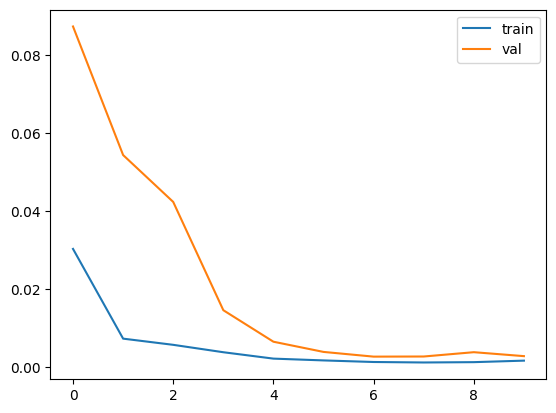

4/4 [==============================] - 0s 3ms/step
mae: 1.2333085341438417


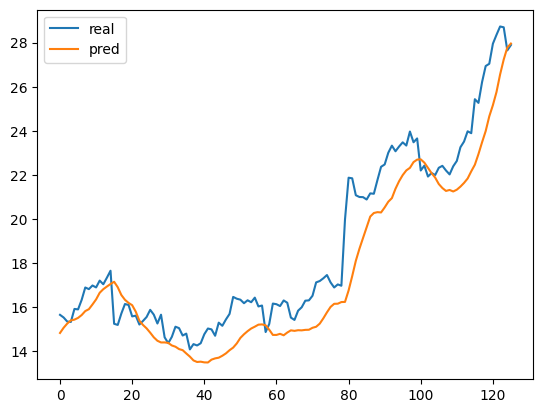

Epoch 1/100
24/24 [==============================] - 2s 33ms/step - loss: 0.0313 - val_loss: 0.0523
Epoch 2/100
24/24 [==============================] - 1s 28ms/step - loss: 0.0226 - val_loss: 0.0678
Epoch 3/100
24/24 [==============================] - 1s 30ms/step - loss: 0.0053 - val_loss: 0.0270
Epoch 4/100
24/24 [==============================] - 1s 29ms/step - loss: 0.0043 - val_loss: 0.0098
Epoch 5/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0054 - val_loss: 0.0078
Epoch 6/100
24/24 [==============================] - 1s 28ms/step - loss: 0.0058 - val_loss: 0.0260
Epoch 7/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0078 - val_loss: 0.0235
Epoch 8/100
24/24 [==============================] - 1s 27ms/step - loss: 0.0051 - val_loss: 0.0089


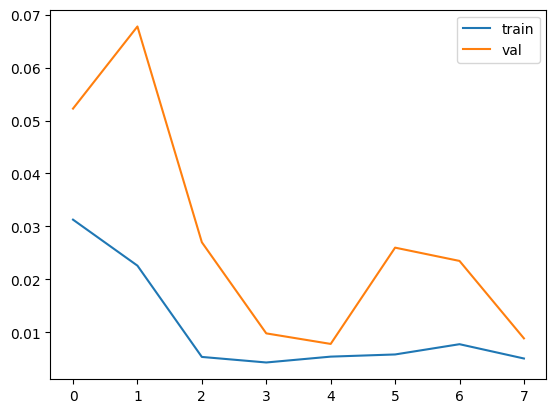

4/4 [==============================] - 0s 3ms/step
mae: 3.158102648819212


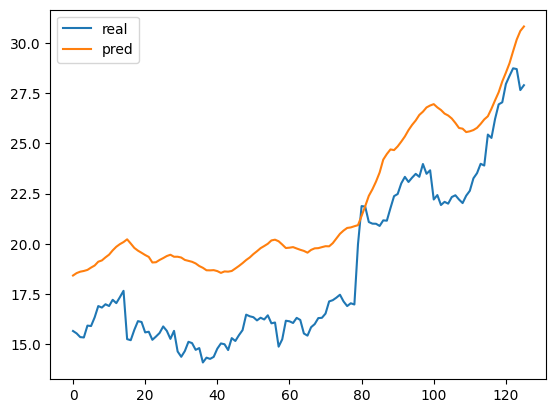

Epoch 1/100
30/30 [==============================] - 2s 32ms/step - loss: 0.0203 - val_loss: 0.0088
Epoch 2/100
30/30 [==============================] - 1s 29ms/step - loss: 0.0238 - val_loss: 0.0661
Epoch 3/100
30/30 [==============================] - 1s 28ms/step - loss: 0.0251 - val_loss: 0.0418
Epoch 4/100
30/30 [==============================] - 1s 28ms/step - loss: 0.0083 - val_loss: 0.0101


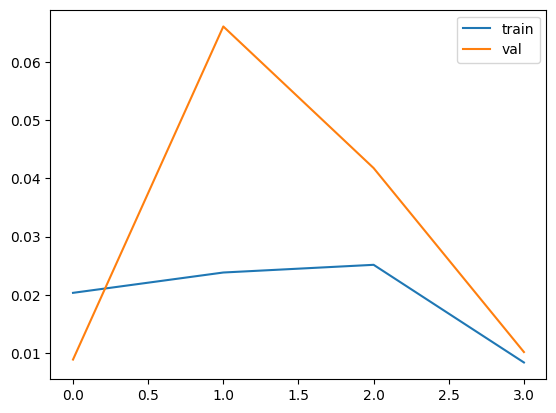

4/4 [==============================] - 0s 4ms/step
mae: 1.553469706022717


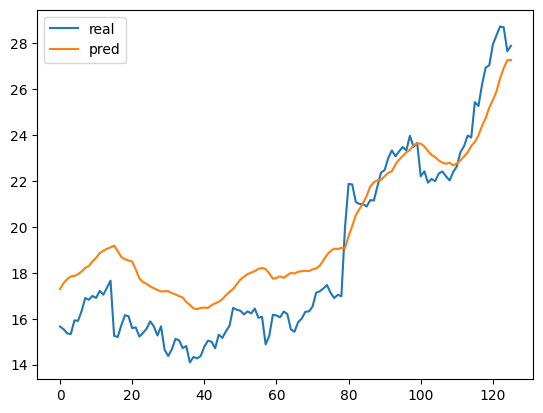

In [38]:
tscv = TimeSeriesSplit(n_splits=5)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=3)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(Bidirectional(LSTM(64,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=False)))
    #model.add(LSTM(3,activation='relu',return_sequences=False))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape

    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    

    print('mae:',np.mean(np.abs(pred-y_test)))

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()


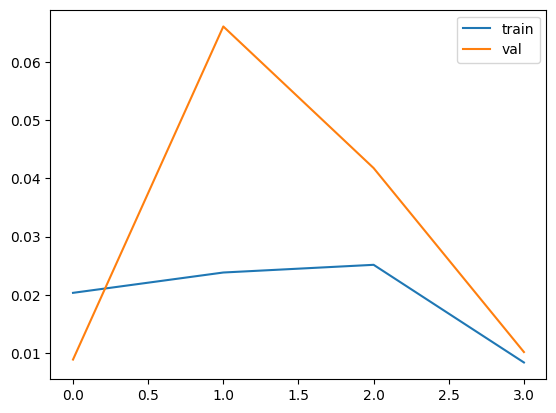

In [39]:
# plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [40]:
#evaluate model
